## Settings

In [3]:
import warnings
import os
import sys
from sys import platform
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config
from utils import get_ds_statistics, get_model_type

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, accuracy_score, precision_score, recall_score, f1_score

#print actual location from root (i'm using a virtual environment but i need to know the actual location on the disk)


In [5]:
_config = get_global_config()
DATA_PATH = os.path.join(BASE_PATH, _config.get('DATASET_PATH'))
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH_SHARED'))
DATASET_FILE = os.path.join(BASE_PATH, _config.get('DATASET_FILE'))
if platform == 'win32':
	DATA_PATH = DATA_PATH.replace('/', '\\')
	RESULTS_PATH = RESULTS_PATH.replace('/', '\\')
	DATASET_FILE = DATASET_FILE.replace('/', '\\')
EMISSIONS_FILE = 'emissions.csv'
METRICS_FILE = 'metrics.csv'
PARAMS_FILE = 'params.csv'

In [3]:
data = pd.DataFrame({
	# Related to dataset
    'n_users': [],
    'n_items': [],
    'n_inter': [],
    'sparsity': [],

    # Related to KG dataset
	'kg_entities': [],
	'kg_relations': [],
	'kg_triples': [],
	'kg_items': [],

	# Related to hardware
    'cpu_cores': [],
    'ram_size': [],
    'is_gpu': [],

	# Related to model
	'model_name': [],
    'model_type': [],

	# Label
	'emissions': []
})

## Features extraction

In [4]:
experiments = []
for d in next(os.walk(RESULTS_PATH))[1]:
	for m in next(os.walk(RESULTS_PATH + d))[1]:
		experiments.append(os.path.join(d, m))
experiments = sorted(experiments)

In [5]:
for i, v in enumerate(experiments):
	e = pd.read_csv(os.path.join(RESULTS_PATH, v, EMISSIONS_FILE))
	dataset = v.split("/")[0]
	model = v.split("/")[1]
	stats = get_ds_statistics(os.path.join(DATA_PATH, dataset))
	for _, row in e.iterrows():
		data.loc[len(data)] = [
			stats['n_users'],
			stats['n_items'],
			stats['n_inter'],
			stats['sparsity'],
			stats['kg_entities'],
			stats['kg_relations'],
			stats['kg_triples'],
			stats['kg_items'],
			row['cpu_count'],
			row['ram_total_size'],
			row['gpu_count'] if row['gpu_count'] == 1. else .0,
			model,
			get_model_type(model),
			row['emissions'],
		]

In [6]:
data.sample()

,n_users,n_items,n_inter,sparsity,kg_entities,kg_relations,kg_triples,kg_items,cpu_cores,ram_size,is_gpu,model_name,model_type,emissions
1,22155,54458,1465871,0.998785,26315,16,96476,11446,12,7.715965,1,Pop,general,0.000011


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   n_users       5 non-null      int64  
 1   n_items       5 non-null      int64  
 2   n_inter       5 non-null      int64  
 3   sparsity      5 non-null      float64
 4   kg_entities   5 non-null      int64  
 5   kg_relations  5 non-null      int64  
 6   kg_triples    5 non-null      int64  
 7   kg_items      5 non-null      int64  
 8   cpu_cores     5 non-null      int64  
 9   ram_size      5 non-null      float64
 10  is_gpu        5 non-null      int64  
 11  model_name    5 non-null      object 
 12  model_type    5 non-null      object 
 13  emissions     5 non-null      float64
dtypes: float64(3), int64(9), object(2)
memory usage: 600.0+ bytes


In [8]:
# UNCOMMENT TO SAVE CSV DATASET

# if not os.path.isfile(DATASET_FILE):
# 	os.unlink(DATASET_FILE)
# data.to_csv(DATASET_FILE, index=False, encoding='utf-8')

## Preprocessing

In [6]:
data = pd.read_csv(DATASET_FILE, encoding='utf-8')
data = data.sort_values(by='emissions')
data = data.iloc[:-7]
data = data.sort_index()

In [7]:
# Null values check
#data.isnull().any()
#for each feature print "feature_name: ", unique_values for feature_name
for col in data.columns:
    print(col, ":", data[col].unique())

n_users : [22155 23679  6040]
n_items : [54458  4414  3706]
n_inter : [1465871 1048575 1000209]
sparsity : [0.99878504 0.98996762 0.95531637]
kg_entities : [26315     0 79347]
kg_relations : [16  0 49]
kg_triples : [ 96476      0 385923]
kg_items : [11446     0  3655]
cpu_cores : [12  4]
ram_size : [64.         16.         27.40581512]
is_gpu : [1. 0.]
model_name : ['BPR' 'CDAE' 'CFKG' 'CKE' 'DGCF' 'DMF' 'DiffRec' 'ENMF' 'FISM' 'GCMC'
 'ItemKNN' 'KGCN' 'KGIN' 'KGNNLS' 'KTUP' 'LDiffRec' 'LINE' 'LightGCN'
 'MKR' 'MacridVAE' 'MultiDAE' 'MultiVAE' 'NCEPLRec' 'NCL' 'NGCF' 'NeuMF'
 'Pop' 'Random' 'RecVAE' 'RippleNet' 'SGL' 'SLIMElastic' 'SimpleX'
 'SpectralCF' 'EASE' 'NAIS' 'ADMMSLIM' 'ConvNCF' 'NNCF']
model_type : ['general' 'knowledge']
emissions : [5.36720786e-04 2.01662448e-02 5.89293690e-03 9.12661421e-04
 1.68196986e-02 2.52643583e-04 5.67541674e-03 4.41081665e-03
 1.80379802e-04 3.88620718e-03 1.96862358e-02 1.33748597e-03
 9.23698594e-03 2.34421743e-03 6.70934471e-02 7.76373893e-04
 

In [8]:
# Turn categorical features into numerical
data.loc[data['model_type'] == 'general', 'model_type'] = 0
data.loc[data['model_type'] == 'knowledge', 'model_type'] = 1
mymap = sorted(list(set(data['model_name'])))
for _, v in enumerate(mymap):
	data.loc[data['model_name'] == v, 'model_name'] = mymap.index(v)

In [9]:
# Turn continuous output values into discrete values
interval = (data['emissions'].max() - data['emissions'].min()) / 3
low_bound = data['emissions'].min() + interval
high_bound = data['emissions'].max() - interval

data_class = data.copy()
data_class.loc[data_class['emissions'] >= high_bound, 'emissions'] = 2
data_class.loc[(data_class['emissions'] > low_bound) & (data_class['emissions'] < high_bound), 'emissions'] = 1
data_class.loc[data_class['emissions'] <= low_bound, 'emissions'] = 0

In [10]:
data_class.emissions.value_counts()

emissions
0.0    175
1.0     12
2.0      6
Name: count, dtype: int64

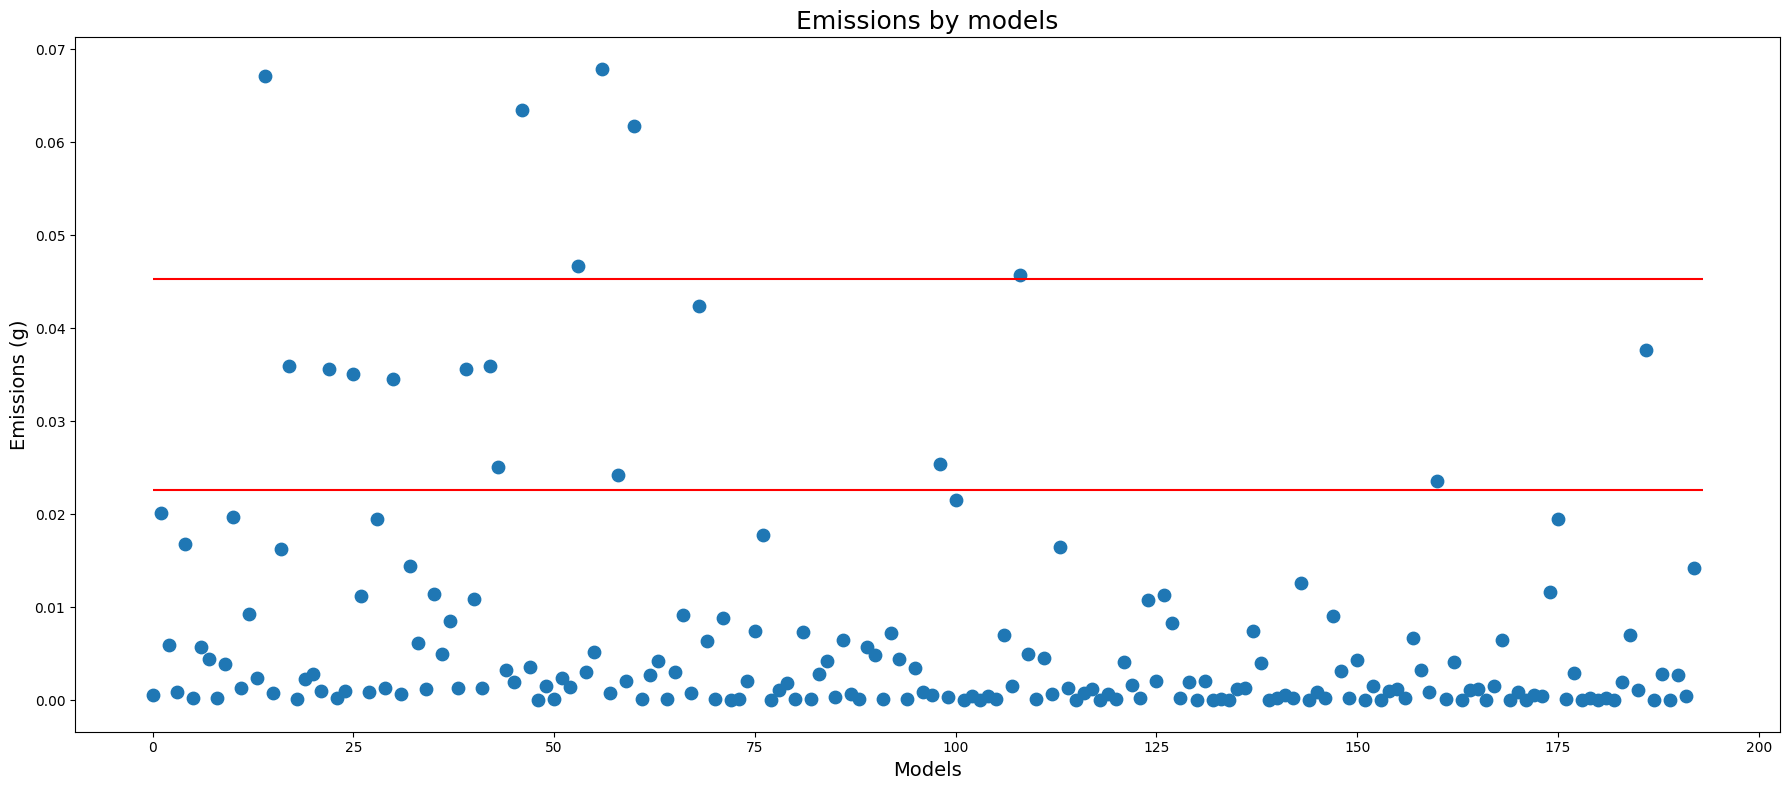

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(18, 8))
axs.scatter(range(len(data['emissions'])), data['emissions'], s=80)
axs.hlines(low_bound, 0, len(data['emissions']), colors='r')
axs.hlines(high_bound, 0, len(data['emissions']), colors='r')
axs.set_title('Emissions by models', fontsize=18)
axs.set_xlabel('Models', fontsize=14)
axs.set_ylabel('Emissions (g)', fontsize=14)
fig.tight_layout()
plt.show()

## Models definition

In [12]:
#from sklearn.decomposition import PCA
X = data.loc[:, data.columns != 'emissions']
y = data[['emissions']]
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype('float64'),
    y.values.astype('float64'),
    train_size = .7,
    test_size = .3,
    random_state = 2,
    shuffle = True
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

REGRESSOR                MAE              RMSE              MSLE

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


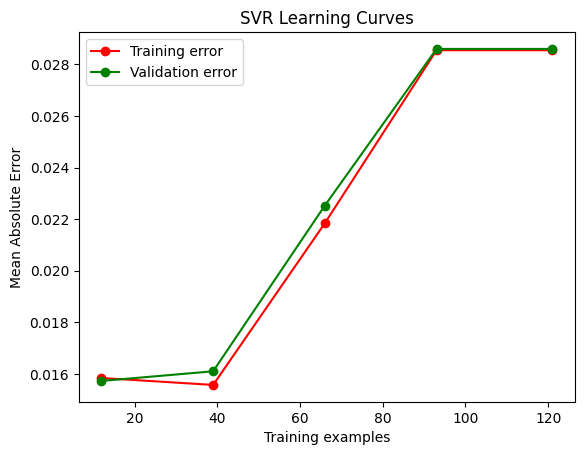


SVR                 0.0288215         0.0008862         0.0008537
Fitting 5 folds for each of 2560000 candidates, totalling 12800000 fits


: 

In [13]:
print(''.join(['> ' for i in range(35)]))
print(f'\n{"REGRESSOR":<20}{"MAE":>8}{"RMSE":>18}{"MSLE":>18}\n')
print(''.join(['> ' for i in range(35)]))

'''
PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X_scaled)

# Ottieni i nomi delle componenti principali
pca_component_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
# Stampa i nomi delle componenti principali
print("Nomi delle componenti principali dopo PCA:")
print(pca_component_names)

X_train, X_test, y_train, y_test=train_test_split(
    X_pca,
    y.values.astype('float64'),
    train_size=0.7,
    test_size=0.3,
    random_state=2,
    shuffle=True
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)
'''

'''
#Feature selection with Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve


# Definisci il modello Lasso
lasso_model = Lasso()

# Definisci i parametri da testare durante la ricerca degli iperparametri
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [10000000]}

# Inizializza la ricerca degli iperparametri con cross-validation
lasso_cv = GridSearchCV(lasso_model, param_grid, cv=5)

# Addestramento del modello con ricerca degli iperparametri
lasso_cv.fit(X, y)

# Estrai il miglior modello
best_lasso_model = lasso_cv.best_estimator_

# Estrai le feature con peso diverso da 0
selected_features = np.where(best_lasso_model.coef_ != 0)[0]

# Stampa le feature selezionate
print("Feature selezionate con peso diverso da 0:")
for feature in selected_features:
    print(f"Feature {feature}: {best_lasso_model.coef_[feature]}")

# Stampa i nomi delle feature selezionate
print("Selected features:")
for feature in selected_features:
    print(f"{X.columns[feature]}")

# Riforma il dataset con le feature selezionate
X_selected = X.iloc[:, selected_features]

# Dividi il dataset in set di addestramento e test con le feature selezionate
X_train, X_test, y_train, y_test = train_test_split(
    X_selected.values.astype('float64'),
    y.values.astype('float64'),
    train_size=.7,
    test_size=.3,
    random_state=2,
    shuffle=True
)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)
'''

model = SVR()


import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('SVR Learning Curves')
plt.show()

model.fit(X_train, y_train)
pred = model.predict(X_test)

mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"SVR":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')



# Define the parameter grid
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [3, 5, 7,10,20],
    'min_samples_split': [2, 5, 10,15,20],
    'splitter': ['best', 'random'],
    'min_samples_leaf': [1, 2, 4,8,10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3],
    'max_features': ['sqrt', 'log2'],
    'random_state': [3],
    'max_leaf_nodes': [None, 5, 10, 20],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3],
    'monotonic_cst': [None, [1, -1], [-1, 1], [-1, -1], [1, 1]],

}

from sklearn.pipeline import Pipeline

# Create the DecisionTreeRegressor model
model = DecisionTreeRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5,n_jobs=-1,verbose=1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_params)

#model = DecisionTreeRegressor(max_depth=5, random_state=3)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('Decision Tree Learning Curves')
plt.show()


model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"DECISION TREE":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')



model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=3)

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('RandomForestRegressor Learning Curves')
plt.show()

model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"RANDOM FOREST":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

model = AdaBoostRegressor(n_estimators=500, random_state=3)


train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('AdaBoost Regressor Learning Curves')
plt.show()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"ADABOOST":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

In [ ]:
X = data_class.loc[:, data_class.columns != 'emissions']
y = data_class[['emissions']]
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype('float64'),
    y.values.astype('float64'),
    train_size = .7,
    test_size = .3,
    random_state = 2,
    shuffle = True,
	stratify=y
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

In [ ]:
'''
PCA
col_names = X.columns.tolist()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X_scaled)


# Crea un DataFrame con le nuove componenti principali e nomi delle colonne originali
df_pca = pd.DataFrame(data=X_pca, columns=[f'PCA{i+1}' for i in range(X_pca.shape[1])])

# Stampa le prime righe del DataFrame con le nuove componenti principali e nomi originali
print("DataFrame con le componenti principali e nomi originali dopo PCA:")
print(pd.concat([df_pca, X[col_names]], axis=1).head())



X_train, X_test, y_train, y_test=train_test_split(
    X_pca,
    y.values.astype('float64'),
    train_size=0.7,
    test_size=0.3,
    random_state=2,
    shuffle=True
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)










LASSO
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split


# Definisci il modello Lasso
lasso_model = Lasso()

# Definisci i parametri da testare durante la ricerca degli iperparametri
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Inizializza la ricerca degli iperparametri con cross-validation
lasso_cv = GridSearchCV(lasso_model, param_grid, cv=5)

# Addestramento del modello con ricerca degli iperparametri
lasso_cv.fit(X, y)

# Estrai il miglior modello
best_lasso_model = lasso_cv.best_estimator_

# Estrai le feature con peso diverso da 0
selected_features = np.where(best_lasso_model.coef_ != 0)[0]

# Stampa le feature selezionate
print("Feature selezionate con peso diverso da 0:")
for feature in selected_features:
    print(f"Feature {feature}: {best_lasso_model.coef_[feature]}")

# Stampa i nomi delle feature selezionate
print("Selected features:")
for feature in selected_features:
    print(f"{X.columns[feature]}")

# Riforma il dataset con le feature selezionate
X_selected = X.iloc[:, selected_features]

# Dividi il dataset in set di addestramento e test con le feature selezionate
X_train, X_test, y_train, y_test = train_test_split(
    X_selected.values.astype('float64'),
    y.values.astype('float64'),
    train_size=.7,
    test_size=.3,
    random_state=2,
    shuffle=True
)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)




'''
print(''.join(['> ' for i in range(42)]))
print(f'\n{"CLASSIFIER":<20}{"ACCURACY":>8}{"PRECISION":>18}{"RECALL":>18}{"F1_SCORE":>18}\n')
print(''.join(['> ' for i in range(42)]))
warnings.filterwarnings('ignore')
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro', labels=np.unique(pred))
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"SVR":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')


#Feature selection with Lasso
from sklearn.model_selection import GridSearchCV



model = DecisionTreeClassifier(max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"DECISION TREE":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"RANDOM FOREST":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

model = AdaBoostClassifier(n_estimators=20, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"ADABOOST":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')